# <center>Lab 9: Multiclass Classification, Deep Learning, and Architecture Search</center>
<center>DATA 558, Spring 2021</center>
<center>Instructor: Zaid Harchaoui</center>
<center>TAs: Alec Greaves-Tunnell and Ronak Mehta</center>


## 0. Overview

In this lab, we will:
- Implement three methods for extending classification to the multiclass setting.
- Introduce Pytorch, a framework for differentiable machine learning.
- Show how to implement simple neural network models in Pytorch.
- Address the issue of scaling to large data with stochastic gradient descent (SGD).
- Demonstrate a method for efficient and statistically principled comparison of many model architectures.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import pickle
import itertools

from sklearn.linear_model import LogisticRegression

## 1. Multiclass Classification

The broad theme of this lab is to introduce tools to handle "scaling" of a data science problem along one of several dimensions: the number of classes, the number of examples, or the number of models to consider. We begin with the first of these issues, generalizing binary classification to the multiclass case.

In [ ]:
# data
dat = pd.read_csv('https://vincentarelbundock.github.io/Rdatasets/csv/Stat2Data/Hawks.csv')
hawks = dat[['Tail','Wing','Species']].dropna()

X = hawks[['Tail', 'Wing']]
f, g = pd.factorize(hawks['Species'])

In [ ]:
hawks['Species'].value_counts()

#### 1.1 One-vs-rest

Let the response $Y$ take values in $\{1, 2, ..., C\}$. In the one-vs-rest framework, we train $C$ binary classifiers, each of which attempts to distinguish a single class from all other classes. Formally, we define

$$
y_i^{(c)} = \mathbb{1}\{y_i = c\}
$$

and we estimate

$$
\beta^{(c)} = \text{argmin}_{\beta \in \mathbb{R}^d} \frac{1}{n}\sum_{i=1}^n \ell(y_i^{(c)}, x_i; \beta^{(c)}) + \frac{1}{2}\lambda ||\beta^{(c)}||_2^2
$$

for every $c \in C$. This involves solving $|C|$ optimization problems on a dataset with $n$ observations. Predictions are obtained by taking the class $c$ that maximizes the predicted probability of the class. In the case of logistic regression, this is equivalent to

$$
\hat{f}(x) = \text{argmax}_{c \in \{1, ..., C\}} x^T\beta^{(c)}.
$$


In [ ]:
clfs = {}
for d in np.unique(f):
    y_binary = np.where(f==d, 1, -1)
    lr = LogisticRegression(C=1e-2, max_iter=350).fit(X, y_binary)
    clfs[d] = {'model': lr,
              'target': y_binary}
    
    preds = lr.predict(X)
    print('Target = {}'.format(d))
    print('Train acc = {:.3f}'.format(np.mean(preds==y_binary)))
    print('-'*20)

In `scikit-learn`, the one-vs-rest framework is implemented as a multiclass option for the `LogisticRegression` class. It is easy to check that the results are identical to training the collection of models defined above.

In [ ]:
clf = LogisticRegression(C=1e-2,
                         max_iter=350, 
                         multi_class='ovr').fit(X, f) # compare to sklearn

clf.coef_ # (n_class x d) coefficient array

In [ ]:
[clfs[d]['model'].coef_ for d in clfs.keys()]

__Exercise 1.1__: Implement one-vs-rest prediction on the data `X` using the models in `clfs`. Validate your prediction method by comparison to `sklearn`.

In [ ]:
def ovr_predict(clfs, X):
    ## <YOUR CODE HERE>
    scores = np.hstack([clfs[d]['model'].predict_proba(X)[:, 1][:, None] for d in clfs.keys()])
    return np.argmax(scores, axis=1)

In [ ]:
ovr_preds = ovr_predict(clfs, X)
np.mean(ovr_preds==clf.predict(X)) # compare predictions to sklearn

In [ ]:
np.mean(ovr_preds==f) # compute accuracy

Finally, we'll visualize the resulting multiclass classifier by plotting the _decision boundaries_ over a region containing the data.

In [ ]:
# plot results over a grid
def plot_multiclass_boundaries(X, f, grid_x, grid_y, grid_z,
                              markers = ['x', 'o', 'v']):
    plt.figure()
    plt.contourf(grid_x, grid_y, grid_z, cmap=plt.cm.Set2)
    for m, cls in enumerate(np.unique(f)):
        ix = f==cls
        plt.scatter(X.iloc[ix,0], X.iloc[ix,1], marker=markers[m], color=plt.cm.Set1(m))
    plt.title("Multiclass decision surface")
    plt.xlabel(X.columns[0])
    plt.ylabel(X.columns[1])
    plt.show()

In [ ]:
# grid setup
step = 1.0 
x_min, x_max = X.iloc[:, 0].min() - 1, X.iloc[:, 0].max() + 1
y_min, y_max = X.iloc[:, 1].min() - 1, X.iloc[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, step),
                     np.arange(y_min, y_max, step))

Z = ovr_predict(clfs, np.c_[xx.ravel(), yy.ravel()])

In [ ]:
plot_multiclass_boundaries(X, f, xx, yy, Z.reshape(xx.shape))

#### 1.2 One-vs-one

Alternatively, we could train a collection of binary classifiers to distinguish between each _pair_ of classes, and then aggregate over the head-to-head prediction results to obtain a multiclass prediction. This approach is known as "one-vs-one", and it involves _reducing_ the data to every possible binary classification problem instead of _transforming_ it as in the one-vs-rest approach.

For a training dataset in which $|C|$ classes are observed, there are 

$$
{|C| \choose 2} = \frac{|C|(|C|-1)}{2} \approx |C|^2
$$

unique pairs of classes - and thus models to train under the one-vs-one approach. The quadratic scaling in $C$ means that this approach can grow infeasible if the number of classes is large. On the other hand, the size of the data per classifier may be much smaller, which is useful for classifiers that scale unfavorably in $n$ (like kernel SVM).

In the one-vs-one framework, predictions are obtained by taking the class that is predicted most frequently across all models in the ensemble.

In [ ]:
clfs = {}
for pair in itertools.combinations(np.unique(f), 2):
    pair_ix = [x in pair for x in f]
    X_pair = X.iloc[pair_ix, :]
    y_pair = f[pair_ix]
    y_pair_binary = np.where(y_pair==pair[1], 1, -1)
    
    lr = LogisticRegression(C=1e-2, 
                            max_iter=350).fit(X_pair, y_pair_binary)
    clfs[pair] = {'model': lr,
                  'pair': pair,
              'target': y_pair_binary}
    
    preds = lr.predict(X_pair)
    print('Pair = {}'.format(pair))
    print('Train acc = {:.3f}'.format(np.mean(preds==y_pair_binary)))
    print('-'*20)

In `scikit-learn`, the `OneVsOneClassifier` class takes any estimator object with `fit()` and `predict_proba()` methods. We can again compare the results to our manual implementation above.

In [ ]:
from sklearn.multiclass import OneVsOneClassifier
ovo_lr = OneVsOneClassifier(LogisticRegression(C=1e-2, max_iter=350)).fit(X, f)

In [ ]:
[x.coef_ for x in ovo_lr.estimators_]

In [ ]:
[x['model'].coef_ for x in clfs.values()]

__Exercise 1.2__: Implement one-vs-one prediction on the data `X` using the models in `clfs`. Validate your prediction method by comparison to `sklearn`. You may wish to use the `scipy.stats` function `mode` (imported below) to compute the most frequent value along some axis of an array.

In [ ]:
from scipy.stats import mode

def ovo_predict(clfs, X):
    ## <YOUR CODE HERE>
    votes = np.hstack([np.array([clfs[pair]['pair'][x] 
                                 for x in clfs[pair]['model'].predict(X)])[:, None] 
                       for pair in pairs])
    return mode(votes, axis=1)[0][:, 0]

In [ ]:
ovo_preds = ovo_predict(clfs, X)
np.mean(ovo_preds==ovo_lr.predict(X))

In [ ]:
np.mean(ovo_preds==f) # compute accuracy

In [ ]:
# plots
Z = ovo_predict(clfs, np.c_[xx.ravel(), yy.ravel()])
plot_multiclass_boundaries(X, f, xx, yy, Z.reshape(xx.shape))

#### 1.3 Multinomial loss

Finally, as an alternative to generating a multiclass prediction from an ensemble of binary classifiers, we can consider directly estimating a statistical model for a categorical outcome $Y$ that takes more than two values. The random variable $Y$ has a categorical distribution if it satisfies

$$
p(Y = c) = p_c
$$

with $0 \leq p_c \leq 1$ for $c=1,...,C$ and $\sum_{c=1}^C p_c = 1$. In multinomial logistic regression, we model the conditional distribution $p(Y | X=x)$ as categorical with probabilities

\begin{align}
p(Y = 1 | X=x) &= \frac{\exp(x^T\beta^{(1)})}{1+\sum_{c=1}^{C-1} x^T\beta^{(c)}}, \\
p(Y = 2 | X=x) &= \frac{\exp(x^T\beta^{(2)})}{1+\sum_{c=1}^{C-1} x^T\beta^{(c)}}, \\
&\vdots \\
p(Y=C | X=x) &= \frac{1}{1+\sum_{c=1}^{C-1} x^T\beta^{(c)}},
\end{align}

where the form of the final probability $p_C$ is chosen to ensure that $\sum_{c=1}^C p_c = 1$.


The multinomial logistic regression optimization problem is then given by

$$
\text{min}_{\beta_1, ..., \beta_C \in \mathbb{R}^d} \frac{1}{n} \sum_{i=1}^n \ell(y_i, x_i; \beta) + \sum_{c=1}^C ||\beta_c||_2^2,
$$
where the _multinomial loss_ writes as
$$
\ell(y_i, x_i; \beta) = \sum_{c=1}^C \mathbb{1}\{y_i = c\} p(Y = c | X=x_i).
$$

Given a new observation $x^*$, the probability $p(Y = c | X=x^*)$ is computed via the expressions above, and we predict

$$
\hat{f}(x^*) = \text{argmax}_{c \in \{1, ..., C\}} \ \ p(Y = c | X=x^*).
$$

Multinomial logistic regression is implemented as an multiclass option for the `LogisticRegression` class:

In [ ]:
clf = LogisticRegression(C=1e-2, 
                         max_iter=350, 
                         multi_class='multinomial').fit(X, f)

In [ ]:
multi_preds = clf.predict(X)
np.mean(multi_preds==f)

In [ ]:
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
plot_multiclass_boundaries(X, f, xx, yy, Z.reshape(xx.shape))

__Exercise 1.3__: What are the relative advantages and disadvantages of the three approaches to multiclass classficiation described above? What is the practical difference in terms of prediction accuracy on the given data?

## 2. PyTorch Basics

In this section, we introduce the syntax of the [PyTorch](https://pytorch.org/) library for deep learning and optimization. Libraries such as PyTorch enable us to run massive computations on the GPU, which is essential for building large-scale neural models. A PyTorch project usually consists of the following components. While these are not very different from the typical components of a machine learning pipeline, they must be implemented in a specific way. 

- **Tensors**: The PyTorch `Tensor` can be thought of as analogous to the `numpy.ndarray`. We often will have tensors that are higher than 2D.
- **Device**: The *device* refers to either CPU or GPU, depending on where models/tensors are stored, and computation happens.
- **Dataset / Dataloader**: We instantiate (and sometimes implement) a `Dataset` class which specifies how to index the training, validation, and test data. This is then used to create a `DataLoader` class which specifies a scheme for loading batches of data, used both in training (e.g. stochastic gradient descent) and validation (e.g. batch-level accuracy). 
- **Architecture / Forward Pass**: We use a `Module` class to specify an *architecture* for our neural network ( layers, activations, etc.). The term *forward pass* refers to the sequence of computations that the network runs on an input given its parameters. Crucially, you implement the forward pass in the `forward` method, and the software uses automatic differentiation algorithms to compute the gradient without hand-coding it.
- **Loss**: This is the final tensor which results from pushing the output of the network and the true labels through a function, usually called `criterion`. After this step, we call `backward` on the loss tensor in order to compute the gradient via the backpropagation algorithm (this is called the *backward pass*).
- **Optimizer**: The `Optimizer` abstraction allows one to compute steps of iterative algorithms such as stochastic gradient descent. We call `step` on this object after the backward pass, which automatically runs the update step.

We put all of these operations together in the *training loop* and *evaluation loop* seen below.

### 2.1. Datasets and Dataloaders

We will use two running examples. A simple simulated dataset $(x_1, y_1), ..., (x_n, y_n)$ with each $y_i \sim \text{Bernoulli}\left(\frac{1}{2}\right)$, and given $y$,
$$
x \sim \begin{cases}
\mathcal{N}(\mu 1_d, \sigma_1 I_d) &\text{ if } y = 1\\
\mathcal{N}(-\mu 1_d, \sigma_0 I_d) &\text{ if } y = 0
\end{cases},
$$
as well as the Fashion MNIST dataset. To implement a `Dataset`,  you must implement a `__len__` method (which returns the number of examples) and a `__getitem__` method, which returns the example at a particular index. Functions such as `TensorDataset` can make it so that you do not have to implement the class yourself.

In [1]:
import torch
from torch.utils.data import Dataset

class SimulatedDataset(Dataset):
    def __init__(self, n, d, mean_scale=0.62, cov_scales=[1.0, 0.5]):
        self.n = n
        self.labels = torch.bernoulli(0.5 * torch.ones(n)).long()
        distributions = [
            torch.distributions.MultivariateNormal(
                -mean_scale * torch.ones(d),
                covariance_matrix=cov_scales[0] * torch.eye(d),
            ),
            torch.distributions.MultivariateNormal(
                mean_scale * torch.ones(d),
                covariance_matrix=cov_scales[1] * torch.eye(d),
            ),
        ]
        self.examples = []
        for i in range(n):
            self.examples.append(distributions[int(self.labels[i])].sample())

    def __len__(self):
        return self.n

    def __getitem__(self, index):
        return self.examples[index], self.labels[index]

After we have a `Dataset`, we can create a `DataLoader`, which is an iterable that cycles through batches of data. Some common schemes for sampling batches are the `RandomSampler` and `SequentialSampler`. Each batch will return a tuple based on the implementation of `__gititem__`.

In [2]:
from torch.utils.data import DataLoader, RandomSampler, random_split

n = 100
d = 10
batch_size = 32
val_size = 0.2

dataset = SimulatedDataset(n, d)

val_len = int(len(dataset) * val_size)
train_len = len(dataset) - val_len

training_data, val_data = random_split(dataset, [train_len, val_len])

train_dataloader = DataLoader(training_data, sampler=RandomSampler(training_data), batch_size=batch_size)
val_dataloader = DataLoader(val_data, sampler=RandomSampler(val_data), batch_size=batch_size)

for i, batch in enumerate(train_dataloader):
    X_batch, y_batch = batch
    
    print("Batch %d:" % i)
    print("\t X shape:", X_batch.shape)
    print("\t y shape:", y_batch.shape)

Batch 0:
	 X shape: torch.Size([32, 10])
	 y shape: torch.Size([32])
Batch 1:
	 X shape: torch.Size([32, 10])
	 y shape: torch.Size([32])
Batch 2:
	 X shape: torch.Size([16, 10])
	 y shape: torch.Size([16])


### 2.2. Architecture

Next, we implement a neural network architecture. This usually amounts to defining *layers*, which are objects that can be called on inputs, in the `__init__` function, and implementing the forward pass in the `forward` function. Below, we implement the simple network below. Let $x \in \mathbb{R}^d$, and consider

$$
p_\theta(y\mid x) = \text{Softmax}(W_2\text{ReLU}(W_1 x + b_1) + b_2),
$$

where

$$
\text{ReLU}(z) = \max\{0, z\}
$$

is applied element-wise, and

$$
\left(\text{Softmax}(z)\right)_i = \frac{e^{z_i}}{\sum_{j=1}^k e^{z_j}}
$$

for $z \in \mathbb{R}^k$. The parameter $\theta = (W_1, b_1, W_2, b_2)$. 

**Exercise 2.1**: If the hidden layer (the vector that results from the ReLU) has dimension $h$, and the Softmaz outputs 2 units, what are the dimensions of $W_1$, $b_1$, $W_2$, $b_2$?

**Solution**:
$$
\begin{align*}
W_1 &\in \mathbb{R}^{h \times d}\\
b_1 &\in \mathbb{R}^h\\
W_2 &\in \mathbb{R}^{2 \times h}\\
b_2 &\in \mathbb{R}^2
\end{align*}
$$

We implement this network below. Notice some of the style choices (the line by line implementation in `forward`), and how the layers are callable objects.

In [3]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        out = self.softmax(x)
        return out

In [4]:
model = SimpleNet(d, d, 2)

### 2.3. Loss and Optimizer

The final elements to specify before we start training are the *loss* and the *optimizer*. PyTorch comes with many built in versions of both of these, so we really just have to specify them by name. You can of course implement your own custom versions as well!

In [5]:
from torch.optim import SGD

criterion = nn.CrossEntropyLoss() # log-loss
optimizer = SGD(model.parameters(), lr=0.1)

### 2.4. Training and Evaluation

We can now put it all together! To train, we run the following loop. We usually measure iterations in *epochs*, or number of passes through the training set. The number of iterations within one batch is the sample size divided by the batch size. We record performance on a validation set after each epoch. We also save a checkpoint of the model.

In [6]:
import random
import numpy as np

def seed_everything(seed_val=42):
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

In [7]:
epochs = 10

seed_everything(seed_val=42)                                          # 0. Seed everything.
device = torch.device("cuda") if torch.cuda.is_available() else "cpu" # 1. Set device.
model.to(device)                                                      # 2. Send model to device.

for epoch in range(epochs):
    
    model.train()                                                     # 3. Set model to training mode.
    
    for (x_batch, y_batch) in train_dataloader:
        
        model.zero_grad()                                             # 4. Prevents gradients from accumulating.
        
        x_batch.to(device)                                            # 5. Send data to device.
        y_batch.to(device)
        outputs = model(x_batch)                                      # 6. Forward pass (compute outputs).
        
        loss = criterion(outputs, y_batch)                            # 7. Compute loss.
        
        loss.backward()                                               # 8. Backward pass (compute gradient).
        
        optimizer.step()                                              # 9. Update parameters.
        
    model.eval()                                                      # 10. Set model to evaluation mode.
    
    val_accuracy = []
    for (x_batch, y_batch) in val_dataloader:
        
        with torch.no_grad():                                         # 11. Do not keep track of operations.
            
            x_batch.to(device)                                        # 12. Send data to device.
            y_batch.to(device)
            outputs = model(x_batch)                                  # 13. Forward pass (compute outputs).
            
            y_pred = torch.argmax(outputs, axis=1)                    # 14. Compute validation performance.
            val_accuracy.append(torch.mean((y_pred == y_batch).float()).item())
    print("Epoch %d validation accuracy: %0.2f" % (epoch, np.array(val_accuracy).mean()))
            
    torch.save(model.state_dict(), "simple_net.pt")                   # 15. Save checkpoint.

Epoch 0 validation accuracy: 0.65
Epoch 1 validation accuracy: 0.75
Epoch 2 validation accuracy: 0.80
Epoch 3 validation accuracy: 0.85
Epoch 4 validation accuracy: 0.90
Epoch 5 validation accuracy: 0.95
Epoch 6 validation accuracy: 0.95
Epoch 7 validation accuracy: 0.95
Epoch 8 validation accuracy: 0.95
Epoch 9 validation accuracy: 0.95


While a lot of these steps might seem overkill for a simple example, we will run through the whole process once again with the Fashion MNIST dataset.

### 2.5. Example: Fashion MNIST

Fashion-MNIST is a dataset of [Zalando](https://jobs.zalando.com/en/tech/?gh_src=nevh2y1)'s article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.

In [8]:
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

training_data = FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [9]:
def get_train_val_dataloaders(dataset, val_size, batch_size):

    if val_size > 0 and val_size < 1:
        val_size = int(val_size * len(dataset))
    train_size = len(dataset) - val_size

    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    print("{:>5,} training samples".format(train_size))
    print("{:>5,} validation samples".format(val_size))

    train_dataloader = DataLoader(
        train_dataset,
        sampler=RandomSampler(train_dataset), 
        batch_size=batch_size, 
    )

    validation_dataloader = DataLoader(
        val_dataset,
        sampler=RandomSampler(val_dataset),  
        batch_size=batch_size,  
    )

    return train_dataloader, validation_dataloader

In [10]:
batch_size = 32
val_size = 0.2

train_dataloader, val_dataloader = get_train_val_dataloaders(training_data, val_size, batch_size)

for x_batch, y_batch in train_dataloader:
    print(x_batch.shape)
    print(y_batch.shape)
    break

48,000 training samples
12,000 validation samples
torch.Size([32, 1, 28, 28])
torch.Size([32])


**Exercise 2.2**: Implement `LessSimpleNet`, which should take an image of size `input_dim`-by-`input_dim`, feed it through `num_layers` fully-connected layers with ReLU activations of size `hidden_dim`, and finally produce a Softmax output layer of size `ouput_dim`. (*Hint:* if you would like to store your layers in a list, use an instance of `nn.ModuleList`.)

In [11]:
class LessSimpleNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LessSimpleNet, self).__init__()
        
        self.layers = nn.ModuleList()

        if num_layers > 0:
            self.layers.append(nn.Linear(input_dim * input_dim, hidden_dim))
            if num_layers > 1:
                for l in range(num_layers - 1):
                    self.layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.layers.append(nn.Linear(hidden_dim, output_dim))
        else:
            # Logistic regression.
            self.layers.append(nn.Linear(input_dim * input_dim, output_dim))

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Flatten.
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)
        
        # Apply fully connected layers.
        x = self.layers[0](x)
        for layer in self.layers[1:]:
            x = F.relu(x)
            x = layer(x)
        out = self.softmax(x)
        return out
    
class ConvNet(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(ConvNet, self).__init__()
        self.conv = nn.Conv2d(1, 4, 5)
        self.bn = nn.BatchNorm2d(4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear((input_dim - 4) ** 2 * 4, 128)
        self.fc2 = nn.Linear(128, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        out = self.softmax(x)
        return out

In [14]:
input_dim = 28   # Size of image.
hidden_dim = 128
num_layers = 2
output_dim = 10  # Number of classes.
lr = 0.01        # Notice the smaller learning rate.
epochs = 10

model = LessSimpleNet(input_dim, hidden_dim, output_dim, num_layers)
# model = ConvNet(input_dim, output_dim)
criterion = nn.CrossEntropyLoss() 
optimizer = SGD(model.parameters(), lr=lr)

We can repeat the same training loop as last time. Because this is a larger scale problem, it can be nice to catch `KeyboardInterrupt` exceptions in case we have to restart.

In [15]:
seed_everything(seed_val=42)                                          
device = torch.device("cuda") if torch.cuda.is_available() else "cpu" 
model.to(device)                                                    

try:
    for epoch in range(epochs):

        model.train()                                                   

        for (x_batch, y_batch) in train_dataloader:

            model.zero_grad()                                           

            x_batch.to(device)                                           
            y_batch.to(device)
            outputs = model(x_batch)                                   

            loss = criterion(outputs, y_batch)                       

            loss.backward()                                           

            optimizer.step()                                             

        model.eval()                                                    

        val_accuracy = []
        for (x_batch, y_batch) in val_dataloader:

            with torch.no_grad():                                        

                x_batch.to(device)                                       
                y_batch.to(device)
                outputs = model(x_batch)                                 

                y_pred = torch.argmax(outputs, axis=1)                    
                val_accuracy.append(torch.mean((y_pred == y_batch).float()).item())

        print("Epoch %d validation accuracy: %0.2f" % (epoch, np.array(val_accuracy).mean()))

        torch.save(model.state_dict(), "less_simple_net.pt")
        # torch.save(model.state_dict(), "conv_net.pt")
except KeyboardInterrupt:
    print("Graceful Exit")

Epoch 0 validation accuracy: 0.78
Epoch 1 validation accuracy: 0.80
Epoch 2 validation accuracy: 0.81
Epoch 3 validation accuracy: 0.83
Epoch 4 validation accuracy: 0.84
Epoch 5 validation accuracy: 0.85
Epoch 6 validation accuracy: 0.85
Epoch 7 validation accuracy: 0.85
Epoch 8 validation accuracy: 0.85
Epoch 9 validation accuracy: 0.86


In [17]:
test_dataloader = DataLoader(test_data, sampler=RandomSampler(test_data), batch_size=1024)

model = LessSimpleNet(input_dim, hidden_dim, output_dim, num_layers)
model.load_state_dict(torch.load("less_simple_net.pt"))
# model = ConvNet(input_dim, output_dim)
# model.load_state_dict(torch.load("conv_net.pt"))
model.eval()

test_accuracy = []
for (x_batch, y_batch) in test_dataloader:
    with torch.no_grad():                                        

        x_batch.to(device)                                       
        y_batch.to(device)
        outputs = model(x_batch)                                 

        y_pred = torch.argmax(outputs, axis=1)                    
        test_accuracy.append(torch.mean((y_pred == y_batch).float()).item())

print("Test accuracy: %0.2f" % np.array(test_accuracy).mean())

Test accuracy: 0.72


## 3. Architecture Search



The networks introduced in the previous section have a number of hyperparameters - namely, `num_layers` and `hidden_dim`. Additionally, our choice of learning rate `lr` will depend on the chosen architecture (for neural networks, the learning rate choice is usually more critical than in convex problems).

One option is grid search. However, given that training each model can take a very long time, especially in larger-scale probelms, intelligent ways of performing hyperparameter and architecture search are increasingly important. We present on such way: **model-racing**. The idea is to start training many models via SGD, but at each step of the way, "knock out" models that are statistically significantly worse than the best model.

Precisely, let $N$ be the number of batches seen thus far, and consider $M$ models $h^{(N)}_1, ..., h^{(N)}_M$, where $h^{(N)}_m$ is the $m$-th model trained with $N$ iterates of (minibatch) stochastic gradient descent. Before training on the $(N+1)$-th batch $B^{(N+1)}$, we compute a running average accuracy $A^{(N+1)}_m$ for each model, given by

$$
\begin{align*}
    A^{(N+1)}_m &= \frac{1}{N+1} \cdot  (\text{accuracy of $h^{(N)}_m$ on $B^{(N+1)}$}) + \frac{N}{N+1} \cdot A^{(N)}_m\\
    A^{(N+1)}_m &= \frac{1}{N+1} \cdot \frac{1}{|B^{(N+1)}|}\sum_{(x, y) \in B^{(N+1)}} \mathbb{I}(y = h^{(N)}_m(x)) + \frac{N}{N+1} \cdot A^{(N)}_m
\end{align*}
$$

While this looks a little hairy, it is just the average of all of the accuracies of the model on all batches before training on them.

$$
\begin{align*}
A^{(N)}_m &= \frac{1}{N}\sum_{n=1}^{N} (\text{accuracy of $h^{(n)}_m$ on $B^{(n)}$})\\
A^{(N)}_m &= \frac{1}{N}\sum_{n=1}^{N} \frac{1}{|B^{(n)}|}\sum_{(x, y) \in B^{(n)}} \mathbb{I}(y = h^{(n)}_m(x))
\end{align*}
$$

Then, let $\delta$ be the chance that we miss the best model (this is specified by us, exactly analogous to $\alpha$ in hypothesis testing). We define bounds around each accuracy to form confidence intervals. That is, given width $w^{(N)}_{m}$, we generate

$$
\text{CI}^{(N)}_{m} = [A^{(N)}_m - w^{(N)}_{m}, A^{(N)}_m + w^{(N)}_{m}]
$$

There are multiple choices of $w^{(N)}_{m}$ that make these valid confidence intervals, derived from theoretical probability bounds. We will not focus on the particular width chosen, but the overall procedure. Finally, we find the highest upper bound, that is

$$
    L^{(N)} = \max_{m=1, ..., M} A^{(N)}_m - w^{(N)}_{m}
$$

This represents the "best" lower limit among the models. We then eliminate the models whose upper limit is lower than this, i.e. any model $m$ that satisfies
$$
    A^{(N)}_m + w^{(N)}_{m} < L^{(N)}
$$

In summary, we create measures of performance for all models while training them, and eliminate a model when its entire confidence interval is lower than that of another model. Crucially, the training step can always be done in parallel. This will be come significantly clearer with a visual, and then pseuodocode.

**Note**: The original model racing algorithm would train leave-one-out models on all batches for each $N$. We use an inexpensive approximation here, by just averaging the accuracies of the previous models.

We generate models by randomly sampling hyperparameters from a specified range. We do this `num_models` times.

In [18]:
import matplotlib.colors as mcolors

def get_model_list(num_models, num_layers_range, hidden_dim_range, lr_range, input_dim, output_dim, device):
    
    num_layers = np.random.choice(num_layers_range, num_models)
    hidden_dim = np.random.choice(hidden_dim_range, num_models)
    lr = np.random.choice(lr_range, num_models)
    
    models = []
    colors = list(mcolors.CSS4_COLORS.keys())
    for i in range(num_models): 
        model = LessSimpleNet(input_dim, hidden_dim[i], output_dim, num_layers[i])
        model.to(device)
        models.append({
            "model" : model,
            "optimizer" : SGD(model.parameters(), lr=lr[i]),
            "id" : i,
            "params" : {"num_layers": num_layers[i], "hidden_dim": hidden_dim[i], "lr": lr[i]},
            "train_accs" : [],
            "intervals" : [],
            "color" : colors[i % 148],
            "eliminated" : False
        })
        
    return models

In [19]:
def train_step(x_batch, y_batch, model_dict, criterion):
    model = model_dict["model"]
    optimizer = model_dict["optimizer"]
    
    model.train()
    model.zero_grad()                                           
    outputs = model(x_batch)                                   
    loss = criterion(outputs, y_batch)                       
    loss.backward()                                           
    optimizer.step()
    
def eval_step(x_batch, y_batch, model_dict):
    model = model_dict["model"]
    
    model.eval()
    with torch.no_grad():                                        

        outputs = model(x_batch)                                 
        y_pred = torch.argmax(outputs, axis=1)           
        return torch.mean((y_pred == y_batch).float()).item()

In [20]:
def bernstein_bound(delta, num_batches, num_models):
    return np.sqrt(2 / (4 * num_batches) * np.log(2 * num_batches * num_models / delta)) + 4 / (3 * num_batches) * np.log(2 * num_batches * num_models / delta)

def update_intervals(batch_accuracy, model_dict, delta, num_batches, num_models):
    
    if num_batches > 1:
        mean = ((num_batches - 1) * model_dict["train_accs"][-1] + batch_accuracy) / num_batches
    else:
        mean = batch_accuracy
    bound = bernstein_bound(delta, num_batches, num_models)
    # bound = hoeffding_bound(delta, num_batches)
    
    return mean, mean - bound, mean + bound

def eliminate(model_list, num_batches):
    
    lower_bounds = []
    for model_dict in model_list:
        if not model_dict["eliminated"]:
            lower_bounds.append(model_dict["intervals"][num_batches - 1][1])
    max_lower_bound = np.max(lower_bounds)
    
    for model_dict in model_list:
        if not model_dict["eliminated"]:
            # Upper bound exceeds maximum of the lower bounds.
            if model_dict["intervals"][num_batches - 1][2] <= max_lower_bound:
                model_dict["eliminated"] = True

The following hyperparameters determine these ranges.

In [25]:
input_dim = 28   
hidden_dim = 128
num_layers = 1
output_dim = 10 

num_models = 100
num_layers_range = [0, 1, 2]
hidden_dim_range = [64, 128, 256]
lr_range = [1e-3, 1e-2, 1e-1]

parallel = False

epochs = 2
criterion = nn.CrossEntropyLoss() 
delta = 0.1

While this training loop is slightly different than what we have seen before, the structure is largely the same. We have just wrapped up previous boilerplate code into `train_step` and `eval_step`.

In [26]:
import pickle
from joblib import Parallel, delayed

seed_everything(seed_val=42)
step = 5

model_list = get_model_list(num_models, num_layers_range, hidden_dim_range, lr_range, input_dim, output_dim, device)

num_batches = 0
try:
    for epoch in range(epochs):

        for (x_batch, y_batch) in train_dataloader:

            num_batches += 1

            # Send data to device.
            x_batch.to(device)                                       
            y_batch.to(device)

            def worker(model_dict):
                # If this model has not already been knocked out of the race.
                if not model_dict["eliminated"]:
                    # Before training, evaluate accuracy on this batch and update confidence intervals.
                    batch_accuracy = eval_step(x_batch, y_batch, model_dict)
                    mean, lower, upper = update_intervals(batch_accuracy, model_dict, delta, num_batches, num_models)

                    # Now, train on the batch.
                    train_step(x_batch, y_batch, model_dict, criterion)
                    
                    return mean, lower, upper
                else:
                    return (0, 0, 0) # Placeholder for eliminated models.
                
            if parallel:
                intervals = np.array(Parallel(n_jobs=-2)(delayed(worker)(model_dict) for model_dict in model_list))
            else:
                intervals = np.array([worker(model_dict) for model_dict in model_list])
            
            for i, model_dict in enumerate(model_list):
                if not model_dict["eliminated"]:
                    model_dict["train_accs"].append(intervals[i, 0])
                    model_dict["intervals"].append(intervals[i])

            # Eliminate worst performing models.
            if num_batches % step == 0:
                eliminate(model_list, num_batches)

    pickle.dump(model_list, open("model_list.p", "wb"))

except KeyboardInterrupt:
    print("Graceful Exit")

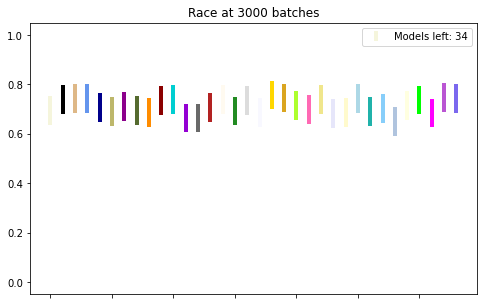

In [27]:
import matplotlib.pyplot as plt
from IPython import display
import time

model_list = pickle.load(open("model_list.p", "rb"))

fig,ax = plt.subplots(figsize=(8,5))

displayed_batches = num_batches
# displayed_batches = 1000

try:
    for frame, nb in enumerate(np.arange(displayed_batches)+1):    
        ax.clear()

        y = []
        colors = []
        remaining_models = 0
        for model_dict in model_list:
            if len(model_dict["train_accs"]) >= nb:
                y.append(model_dict["train_accs"][nb - 1])
                colors.append(model_dict["color"])
                remaining_models += 1
        x = np.arange(remaining_models)
        yerr = bernstein_bound(delta, nb, num_models)

        ax.set_ylim(-0.05, 1.05)
        ax.errorbar(x, y, yerr=yerr, linestyle=' ', ecolor=colors, elinewidth=4)
        ax.set_title("Race at %d batches" % nb)
        ax.set_xticklabels([])
        ax.legend(['Models left: {}'.format(remaining_models)])

        display.clear_output(wait=True)
        display.display(plt.gcf())
        time.sleep(.01)

    display.clear_output(wait=True)

except KeyboardInterrupt:
    print("Graceful Exit")

In [28]:
for model_dict in model_list:
    if not model_dict["eliminated"]:
        print(model_dict["params"])

{'num_layers': 0, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 1, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 0, 'hidden_dim': 64, 'lr': 0.1}
{'num_layers': 1, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 0, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 2, 'hidden_dim': 64, 'lr': 0.1}
{'num_layers': 2, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 2, 'hidden_dim': 128, 'lr': 0.1}
{'num_layers': 1, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 1, 'hidden_dim': 64, 'lr': 0.1}
{'num_layers': 0, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 2, 'hidden_dim': 64, 'lr': 0.1}
{'num_layers': 2, 'hidden_dim': 128, 'lr': 0.1}
{'num_layers': 2, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 1, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 0, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 1, 'hidden_dim': 64, 'lr': 0.1}
{'num_layers': 1, 'hidden_dim': 128, 'lr': 0.1}
{'num_layers': 0, 'hidden_dim': 64, 'lr': 0.1}
{'num_layers': 1, 'hidden_dim': 256, 'lr': 0.1}
{'num_layers': 2, 'hidden_dim': 256, 'lr': 0.1